In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import time
import seaborn as sns
import plotly.graph_objects as go
colors = sns.color_palette('Set2')
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
from sklearn.model_selection import train_test_split



In [2]:
TRAIN_DIR = "train_files"



In [3]:
%time
df_prices = pd.read_csv(os.path.join(TRAIN_DIR, 'stock_prices.csv'))
df_prices_sec = pd.read_csv(os.path.join(TRAIN_DIR, 'secondary_stock_prices.csv'))
df_fins = pd.read_csv(os.path.join(TRAIN_DIR, 'financials.csv'))
df_opts = pd.read_csv(os.path.join(TRAIN_DIR, 'options.csv'))
df_trades = pd.read_csv(os.path.join(TRAIN_DIR, 'trades.csv'))
stock_list = pd.read_csv("D:/PFE/stock_list.csv")

Wall time: 0 ns


In [7]:
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int64  
 3   Open              float64
 4   High              float64
 5   Low               float64
 6   Close             float64
 7   Volume            int64  
 8   AdjustmentFactor  float64
 9   ExpectedDividend  float64
 10  SupervisionFlag   bool   
 11  Target            float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 198.0+ MB


In [4]:
def summarize(df, file_name, n_rows_to_show=5):
    """Simply summarize the given DataFrame.
    
    Parameters:
        df: pd.DataFrame, raw DataFrame
        file_name: str, name of the file
        n_rows_to_show: int, number of rows to show 
    """
    print(f"=====Summary of {file_name}=====")
    print(f"Shape: {df.shape}")
    
    nan_ratio = pd.isna(df).sum() / len(df) * 100
    nan_ratio.sort_values(ascending=False, inplace=True)
    nan_ratio = nan_ratio.to_frame(name='NaN Ratio').T
    print("NaN ratio:")
    display(nan_ratio)   
    
    display(df.head(n_rows_to_show))

In [5]:
summarize(df_prices, "stock_prices.csv")

=====Summary of stock_prices.csv=====
Shape: (2332531, 12)
NaN ratio:


,ExpectedDividend,Open,High,Low,Close,Target,RowId,Date,SecuritiesCode,Volume,AdjustmentFactor,SupervisionFlag
NaN Ratio,99.191222,0.326169,0.326169,0.326169,0.326169,0.010204,0.0,0.0,0.0,0.0,0.0,0.0


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


ExpectedDividend has severe missing, which is related to the frequency of dividends paid. Also, there are some missing prices to notice.


In [6]:
row_id = (df_prices['Date'].apply(lambda date: ''.join(date.split('-'))+'_')
          + df_prices['SecuritiesCode'].astype(str))
assert (df_prices['RowId'] == row_id).all()


RowID is composed of Date and SecuritiesCode.

In [7]:
n_dates=df_prices['Date'].nunique()
date_min,date_max=df_prices['Date'].min(),df_prices['Date'].max()
n_stocks=df_prices['SecuritiesCode'].nunique()
print(f"Number of unique dates :{n_dates} ({date_min} ~ {date_max})\n"
  f"Number of unique stocks: {n_stocks}")


Number of unique dates :1202 (2017-01-04 ~ 2021-12-03)
Number of unique stocks: 2000


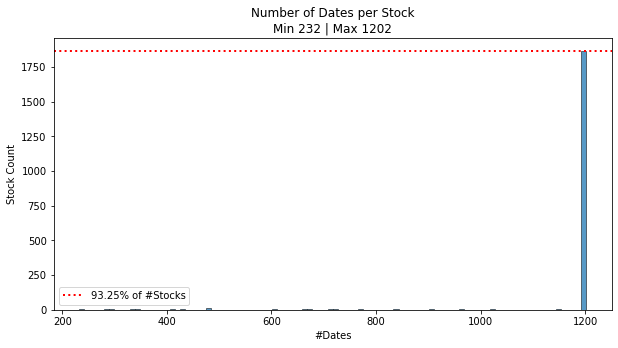

In [8]:
n_dates_per_stock = df_prices.groupby(['SecuritiesCode'])['Date'].count()
stock_cnt_max = (n_dates_per_stock == n_dates_per_stock.max()).sum()
stock_ratio_max = stock_cnt_max / len(n_dates_per_stock) * 100

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=n_dates_per_stock.values, bins=100, palette=colors, ax=ax)
ax.axhline(y=stock_cnt_max, color='red', linestyle='dotted', linewidth=2,
           label=f'{stock_ratio_max}% of #Stocks')
ax.set_title(f"Number of Dates per Stock\nMin {n_dates_per_stock.min()} | "
             f"Max {n_dates_per_stock.max()}")
ax.set_xlabel("#Dates")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

Over 90% of stocks have records for complete training period from 2017-01-04 to 2021-12-03. However, we still need to pay attention to missing values in certain columns (e.g., ExpectedDividend, price columns).

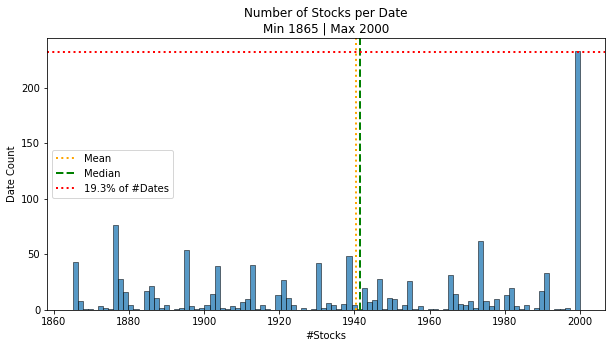

In [9]:
n_stocks_per_date = df_prices.groupby(['Date'])['SecuritiesCode'].count()
date_cnt_max = (n_stocks_per_date == n_stocks_per_date.max()).sum()
date_ratio_max = round(date_cnt_max / len(n_stocks_per_date) * 100, 2)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=n_stocks_per_date.values, bins=100, palette=colors, ax=ax)
ax.axvline(x=n_stocks_per_date.mean(), color='orange', linestyle='dotted',
           linewidth=2, label='Mean')
ax.axvline(x=n_stocks_per_date.median(), color='green', linestyle='--',
           linewidth=2, label='Median')
ax.axhline(y=date_cnt_max, color='red', linestyle='dotted', linewidth=2,
           label=f'{date_ratio_max}% of #Dates')
ax.set_title(f"Number of Stocks per Date\nMin {n_stocks_per_date.min()} | "
             f"Max {n_stocks_per_date.max()}")
ax.set_xlabel("#Stocks")
ax.set_ylabel("Date Count")
ax.legend()
plt.show()

Approximately only 20% of trading dates have all 2000 stocks' records. Again, the missing values should be noted.

In [10]:
df_no_prices=df_prices[df_prices['Close'].isna()]
print(f"Number of sample without Close prices: {len(df_no_prices)}")


Number of sample without Close prices: 7608


In [11]:
max_na_prices=df_no_prices.groupby(df_no_prices['Date'])['SecuritiesCode'].count()
max_na_prices.max()

1988

In [12]:
df_no_prices['Date'].value_counts()

2020-10-01    1988
2017-03-16      15
2019-10-09      14
2019-04-04      14
2021-10-29      13
              ... 
2017-12-25       1
2017-12-26       1
2020-03-13       1
2018-01-04       1
2018-02-21       1
Name: Date, Length: 1175, dtype: int64

In 2020-10-01  1988 stock didn't have a close price which raises a lot of question! let's grapth the data 


In [13]:
no_prices_per_date = df_no_prices['Date'].value_counts().sort_index()
all_dates = sorted(df_prices['Date'].unique())
no_prices_per_date = no_prices_per_date.reindex(all_dates, fill_value=0)

fig = go.Figure()
fig.add_trace(go.Scatter(x=no_prices_per_date.index, 
                         y=no_prices_per_date, 
                         mode='lines'))
rect_focus_params = {
    'xref': 'x', 'yref': 'y', 'x0': '2020-09-25', 'x1': '2020-10-08',
    'y0': 1900, 'y1': 2000, 'line': {'color': 'red', 'width': 1.5}
}
fig.add_shape(type='rect', **rect_focus_params)
fig.update_layout(
    title=f"Number of Stocks without Prices per Date",
    xaxis_title="Date",
    yaxis_title="Stock Count",
)
fig.show()

Number of stocks without prices has a maximum on 2020-10-01. After doing some research, I find that it's because of The Failure of Equity Trading System on October 1, 2020(https://www.jpx.co.jp/english/corporate/news/news-releases/0060/20201019-01.html).

In [14]:
assert (len(df_prices[df_prices['Date'] == '2020-10-01']) 
        == no_prices_per_date.max())

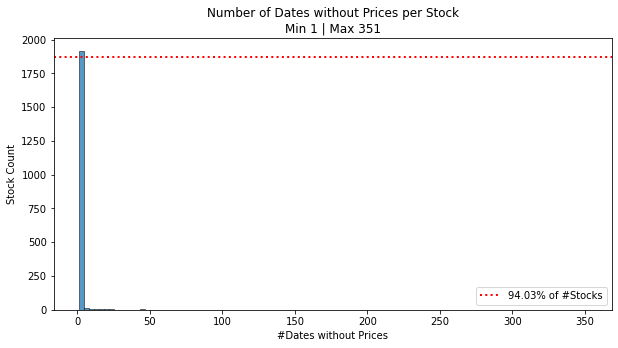

In [15]:
no_prices_per_stock = df_no_prices['SecuritiesCode'].value_counts()
stock_cnt_max = (no_prices_per_stock == no_prices_per_stock.min()).sum()
stock_ratio_max = round(stock_cnt_max / len(no_prices_per_stock) * 100, 2)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=no_prices_per_stock.values, bins=100, palette=colors, ax=ax)
ax.axhline(y=stock_cnt_max, color='red', linestyle='dotted', linewidth=2,
           label=f'{stock_ratio_max}% of #Stocks')
ax.set_title(f"Number of Dates without Prices per Stock\n"
             f"Min {no_prices_per_stock.min()} | "
             f"Max {no_prices_per_stock.max()}")
ax.set_xlabel("#Dates without Prices")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

Over 90% of stocks have only one date with missing prices. And, the culprit is mainly the one I mentioned above, 2020-10-01.

In [16]:
def plot_candle_with_target(stock_code, prime=True):
    """Plot OHLCV plot with target series.
    
    Parameters:
        stock_code: int, code of the stock
        prime: bool, whether the stock to plot is prime or not
    """
    df_ = df_prices.copy() if prime else df_prices_sec.copy()
    df_ = df_[df_['SecuritiesCode'] == stock_code]
    dates = df_['Date'].values
    ohlc = {
        'open': df_['Open'].values, 
        'high': df_['High'].values, 
        'low': df_['Low'].values, 
        'close': df_['Close'].values
    }
    vol = df_['Volume'].values
    target = df_['Target'].values
    
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, x_title='Date')
    fig.add_trace(go.Candlestick(x=dates, name='OHLC', **ohlc),
                  row=1, col=1)
    fig.add_trace(go.Bar(x=dates, y=vol, name='Volume'),
                  row=2, col=1)
    fig.add_trace(go.Scatter(x=dates, y=target, name='Target'),
                  row=3, col=1)
    fig.update_layout(
        title=f"OHLCV Chart with Target Series (Stock {stock_code})",
    )
    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()

In [17]:
for stock_code in df_prices['SecuritiesCode'].unique()[:3]:
    plot_candle_with_target(stock_code)

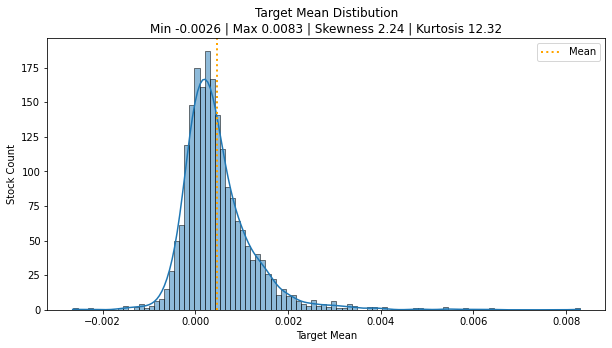

In [18]:
target_mean_per_stock = df_prices.groupby(['SecuritiesCode'])['Target'].mean()
target_mean_mean = target_mean_per_stock.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_mean_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_mean_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Mean Distibution\n"
             f"Min {round(target_mean_per_stock.min(), 4)} | "
             f"Max {round(target_mean_per_stock.max(), 4)} | "
             f"Skewness {round(target_mean_per_stock.skew(), 2)} | "
             f"Kurtosis {round(target_mean_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Target Mean")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

Target mean is a right-skewed distribution. Also, it has a large kurtosis, exhibiting tail data exceeding the tails of the normal distribution. For investors, high kurtosis of the return distribution implies the investor will experience occasional extreme returns (either positive or negative). This phenomenon is known as kurtosis risk. Hence, competitors should be aware of outliers. For more information, please refer to https://www.investopedia.com/terms/k/kurtosis.asp .

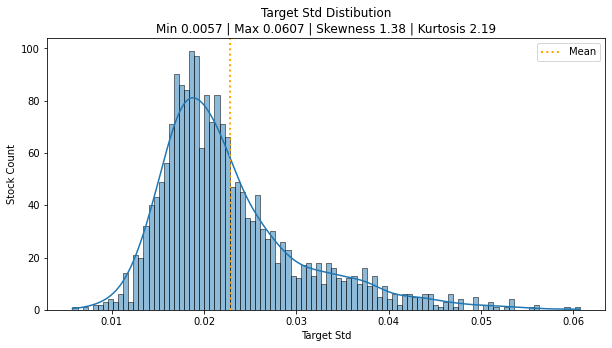

In [19]:
target_std_per_stock = df_prices.groupby(['SecuritiesCode'])['Target'].std()
target_std_mean = target_std_per_stock.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_std_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_std_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Std Distibution\n"
             f"Min {round(target_std_per_stock.min(), 4)} | "
             f"Max {round(target_std_per_stock.max(), 4)} | "
             f"Skewness {round(target_std_per_stock.skew(), 2)} | "
             f"Kurtosis {round(target_std_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Target Std")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()


Target standard deviation is again a right-skewed distribution, where some of the stocks have higher std (up to 0.06).

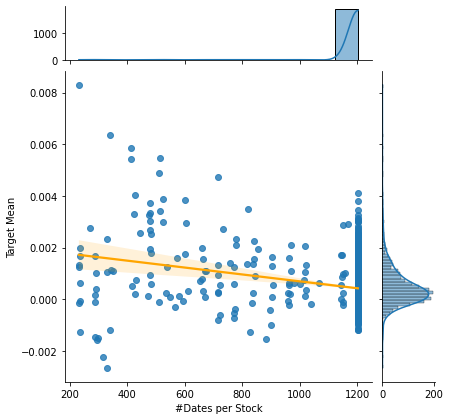

In [20]:
ax = sns.jointplot(x=n_dates_per_stock, y=target_mean_per_stock, 
                   kind="reg", height=6, marginal_ticks=True, 
                   joint_kws={'line_kws':{'color':'orange'}})
ax.ax_joint.set_xlabel('#Dates per Stock')
ax.ax_joint.set_ylabel('Target Mean')
plt.show()


The joint plot of number of dates (i.e., records) per stock and target mean distribution shows that target mean increases proportionally to the number of dates. Moreover, the dispersion of target mean seems to be larger when the number of dates is smaller.



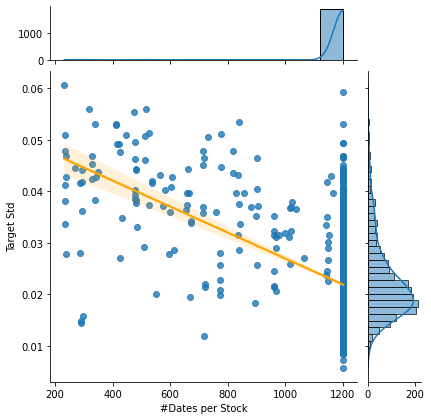

In [21]:
ax = sns.jointplot(x=n_dates_per_stock, y=target_std_per_stock, 
                   kind="reg", height=6, marginal_ticks=True, 
                   joint_kws={'line_kws':{'color':'orange'}})
ax.ax_joint.set_xlabel('#Dates per Stock')
ax.ax_joint.set_ylabel('Target Std')
plt.show()

With smaller number of dates per stock, the target value indeed shows greater dispersion (i.e., greater standard deviation).



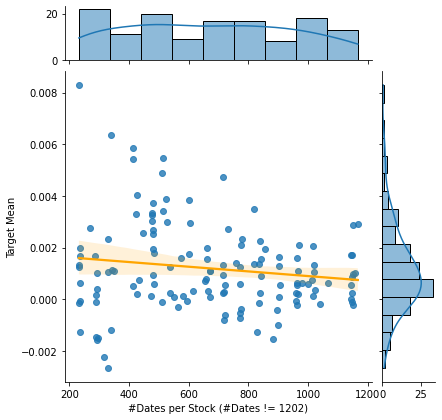

In [22]:
n_dates_per_stock_ = n_dates_per_stock[n_dates_per_stock != 1202]
target_mean_per_stock_ = target_mean_per_stock[target_mean_per_stock.index.isin(n_dates_per_stock_.index)]

ax = sns.jointplot(x=n_dates_per_stock_, y=target_mean_per_stock_, 
                   kind="reg", height=6, marginal_ticks=True, 
                   joint_kws={'line_kws':{'color':'orange'}})
ax.ax_joint.set_xlabel('#Dates per Stock (#Dates != 1202)')
ax.ax_joint.set_ylabel('Target Mean')
plt.show()

Through analysis, we know that over 90% of stocks have records for complete training period (namely 1202 records). Hence, the further analysis removing this majority is done below. And, the conlusion is in line with the observations above, showing that smaller number of dates per stock corresponds to greater dispersion.

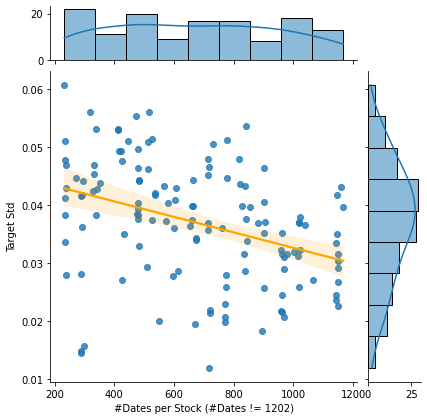

In [23]:
target_std_per_stock_ = target_std_per_stock[target_std_per_stock.index.isin(n_dates_per_stock_.index)]

ax = sns.jointplot(x=n_dates_per_stock_, y=target_std_per_stock_, 
                   kind="reg", height=6, marginal_ticks=True, 
                   joint_kws={'line_kws':{'color':'orange'}})
ax.ax_joint.set_xlabel('#Dates per Stock (#Dates != 1202)')
ax.ax_joint.set_ylabel('Target Std')
plt.show()


In [24]:
tm_max = target_mean_per_stock.max()
stock_tm_max = target_mean_per_stock[target_mean_per_stock == tm_max].index.values[0]

print(f"Stock with max target mean is {stock_tm_max}.")
plot_candle_with_target(stock_tm_max)

Stock with max target mean is 4169.


Stock 4169 is Enechange Ltd, which is a Japan-based energy switching tool developer. We can see that the data starts on December 23, 2020. The IPO(An initial public offering)news can be found here. For more information, please refer to https://enechange.co.jp/en/.
Another thing to mention is that the stock with max target std is also 4169; hence, the analysis isn't repeated.


Now, let's analyze target values from the perspective of date.

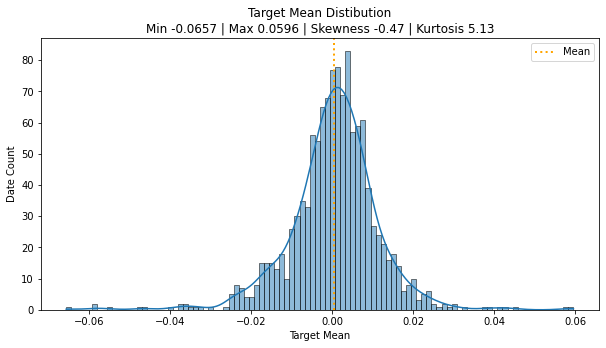

In [25]:
target_mean_per_date = df_prices.groupby(['Date'])['Target'].mean()
target_mean_mean = target_mean_per_date.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_mean_per_date.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_mean_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Mean Distibution\n"
             f"Min {round(target_mean_per_date.min(), 4)} | "
             f"Max {round(target_mean_per_date.max(), 4)} | "
             f"Skewness {round(target_mean_per_date.skew(), 2)} | "
             f"Kurtosis {round(target_mean_per_date.kurtosis(), 2)}")
ax.set_xlabel("Target Mean")
ax.set_ylabel("Date Count")
ax.legend()
plt.show()

 This time, target mean distribution is approximately symmetric. However, it again has a large kurtosis. Hence, outliers should be carefully handled.

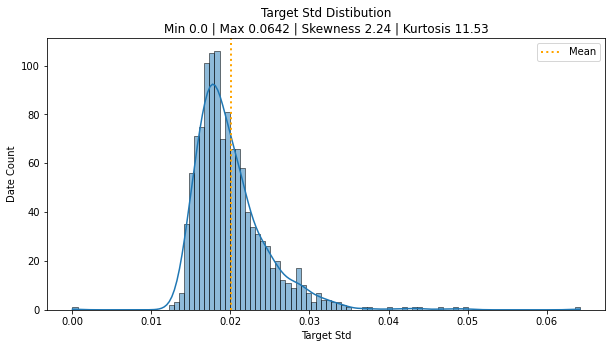

In [26]:
target_std_per_date = df_prices.groupby(['Date'])['Target'].std()
target_std_mean = target_std_per_date.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_std_per_date.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_std_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Std Distibution\n"
             f"Min {round(target_std_per_date.min(), 4)} | "
             f"Max {round(target_std_per_date.max(), 4)} | "
             f"Skewness {round(target_std_per_date.skew(), 2)} | "
             f"Kurtosis {round(target_std_per_date.kurtosis(), 2)}")
ax.set_xlabel("Target Std")
ax.set_ylabel("Date Count")
ax.legend()
plt.show()

Target standard deviation is a right-skewed distribution, where some of the stocks have higher std (up to 0.06). An interesting thing is that the smallest std is zero. Let's see the reason behind the scene.

In [27]:
zero_target_std = target_std_per_date[target_std_per_date == 0].index.values
print(f"The trading dates with zero target std is {zero_target_std}.")

dates_after = df_prices[(df_prices['Date'] >= zero_target_std[0]) & 
                        (df_prices['Date'] < '2020-10-02')]['Date'].unique()
print(f"T+1 trading date of that date is {dates_after[1]}")
print(f"T+2 trading date of that date is {dates_after[2]}")

The trading dates with zero target std is ['2020-09-29'].
T+1 trading date of that date is 2020-09-30
T+2 trading date of that date is 2020-10-01


Now, we understand why target std becomes zero on September 29, 2020. The reason is the failure of trading system on October 1, 2020 as I mention above. Because the prices are missing on T+2 date. It's impossible to derive the target values for September 29, 2020.

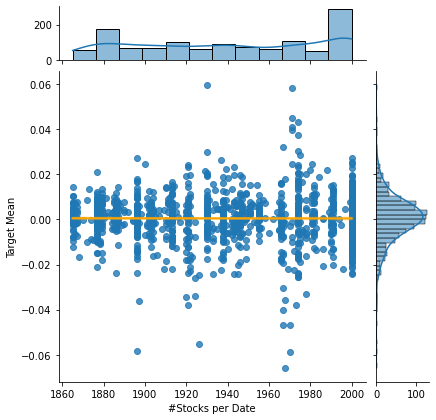

In [28]:
ax = sns.jointplot(x=n_stocks_per_date, y=target_mean_per_date, 
                   kind="reg", height=6, marginal_ticks=True, 
                   joint_kws={'line_kws':{'color':'orange'}})
ax.ax_joint.set_xlabel('#Stocks per Date')
ax.ax_joint.set_ylabel('Target Mean')
plt.show()

The joint plot of number of stocks per date and target mean distribution shows no significant patterns. But, the dispersion slightly increases when number of stocks per date grows

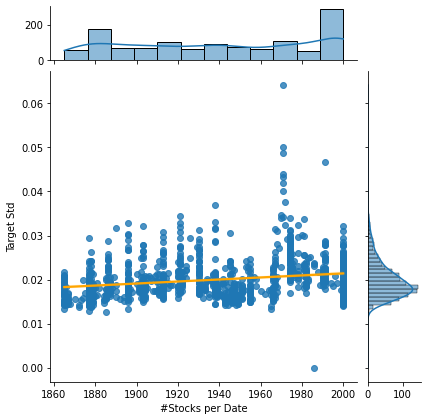

In [29]:
ax = sns.jointplot(x=n_stocks_per_date, y=target_std_per_date, 
                   kind="reg", height=6, marginal_ticks=True, 
                   joint_kws={'line_kws':{'color':'orange'}})
ax.ax_joint.set_xlabel('#Stocks per Date')
ax.ax_joint.set_ylabel('Target Std')
plt.show()

A slight increase of dispersion is observed when number of stocks per date becomes larger.



In [30]:
tm_max = target_mean_per_date.max()
date_tm_max = target_mean_per_date[target_mean_per_date == tm_max].index.values[0]
print(f"Date with max target mean is {date_tm_max}.")

Date with max target mean is 2018-12-25.


The trading date with the max target mean is 2018-12-25. Hence, we can go to see what happened in 2018-12-27, the T+2 trading date. After doing some searching, I find that the reason might be the Wall Street’s biggest point gain in history. https://www.washingtonpost.com/business/2018/12/27/us-markets-stumble-after-wednesdays-big-rebound/

In [31]:
ts_max = target_std_per_date.max()
date_ts_max = target_std_per_date[target_std_per_date == ts_max].index.values[0]
print(f"Date with max target std is {date_ts_max}.")

Date with max target std is 2020-03-17.


The trading date with the max target std is 2020-03-17. Hence, we can go to see what happened in 2020-03-19, the T+2 trading date. The first thought come to my mind is the prevalence of COVID-19. From the following news, we can see what happened at that time:

Asian shares tumble: S.Korea's Kospi drops 9%, Hong Kong 4% (https://mainichi.jp/english/articles/20200319/p2g/00m/0bu/076000c)
Investors shift to cash as fears of a prolonged coronavirus-induced recession.

Stock List Fusion


In [37]:
summarize(stock_list, "stock_list.csv", n_rows_to_show=2)

=====Summary of stock_list.csv=====
Shape: (4417, 16)
NaN ratio:


,NewMarketSegment,TradeDate,Close,IssuedShares,MarketCapitalization,SecuritiesCode,EffectiveDate,Name,Section/Products,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,Universe0
NaN Ratio,14.602671,6.701381,6.701381,6.701381,6.701381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
0,1301,20211230,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,1.092828e+07,3.365911e+10,True
1,1305,20211230,Daiwa ETF-TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2097.0,3.634636e+09,7.621831e+12,False


In [38]:
assert stock_list['Universe0'].sum() == 2000

Universe0 correctly indicates the 2000 target stocks to predict.



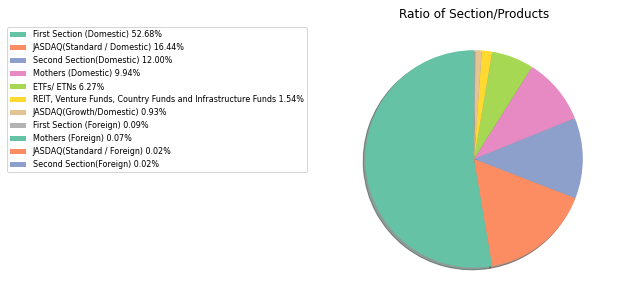

In [39]:
sec_prod_val_cnt = stock_list['Section/Products'].value_counts()
pct = sec_prod_val_cnt / sec_prod_val_cnt.sum() * 100
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_prod_val_cnt.index, pct)]

fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_prod_val_cnt.values, 
                        colors=colors, 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_prod_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Ratio of Section/Products")
plt.show()

First Section (Domestic) dominates Secion/Products of all stocks.


Let's focus on 2000 target stocks

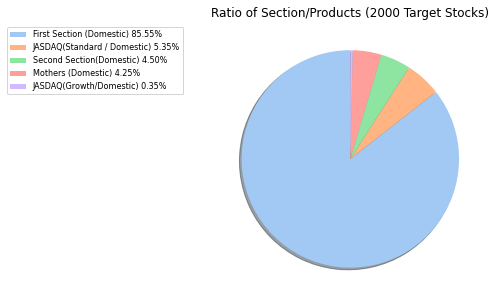

In [40]:
target_stock_list = stock_list[stock_list['Universe0']]
sec_prod_val_cnt = target_stock_list['Section/Products'].value_counts()
pct = sec_prod_val_cnt / sec_prod_val_cnt.sum() * 100
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_prod_val_cnt.index, pct)]

fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_prod_val_cnt.values, 
                        colors=sns.color_palette("pastel"), 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_prod_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Ratio of Section/Products (2000 Target Stocks)")
plt.show()

We can find that First Section (Domestic) still dominates Secion/Products of these stocks. And, the 2000 target stocks can be divided into only 5 categories.

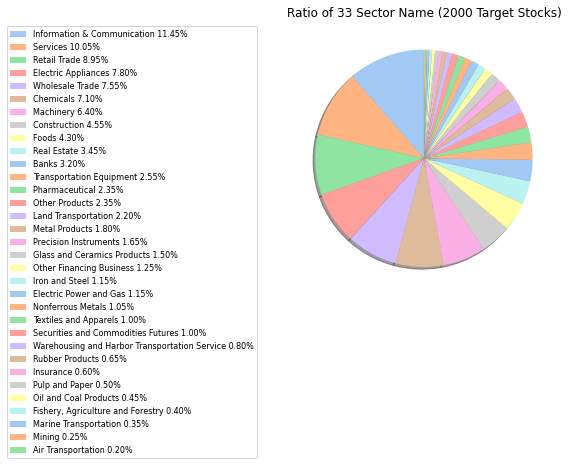

In [41]:
sec_33_val_cnt = target_stock_list['33SectorName'].value_counts()
pct = sec_33_val_cnt / sec_33_val_cnt.sum() * 100
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_33_val_cnt.index, pct)]

fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_33_val_cnt.values, 
                        colors=sns.color_palette("pastel"), 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_33_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Ratio of 33 Sector Name (2000 Target Stocks)")
plt.show()

Stocks in sectors Information & Communication and Services are the majority of the 33 industrial sectors defined by Securities Identification Code Committee (SICC).

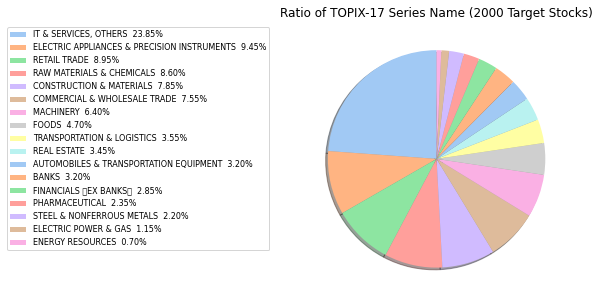

In [42]:
sec_17_val_cnt = target_stock_list['17SectorName'].value_counts()
pct = sec_17_val_cnt / sec_17_val_cnt.sum() * 100
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_17_val_cnt.index, pct)]

fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_17_val_cnt.values, 
                        colors=sns.color_palette("pastel"), 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_33_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Ratio of TOPIX-17 Series Name (2000 Target Stocks)")
plt.show()

Stocks in series IT & SERVICES, OTHERS are the majority of the TOPIX-17 series defined by Securities Identification Code Committee (SICC). And this category is comprised of stocks in sectors Information & Communication, Services, and Other Products, which can be verified by comparing sector ratios with series ratio.



Let's merge sector information with the stock price DataFrame to do some sector-based analysis.



In [43]:
sec_info = target_stock_list[['SecuritiesCode', '33SectorName', '17SectorName']]
df_prices = pd.merge(df_prices, sec_info, on='SecuritiesCode')
df_prices.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,33SectorName,17SectorName
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,"Fishery, Agriculture and Forestry",FOODS
1,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920,"Fishery, Agriculture and Forestry",FOODS
2,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092,"Fishery, Agriculture and Forestry",FOODS
3,20170110_1301,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,-0.005100,"Fishery, Agriculture and Forestry",FOODS
4,20170111_1301,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,-0.003295,"Fishery, Agriculture and Forestry",FOODS


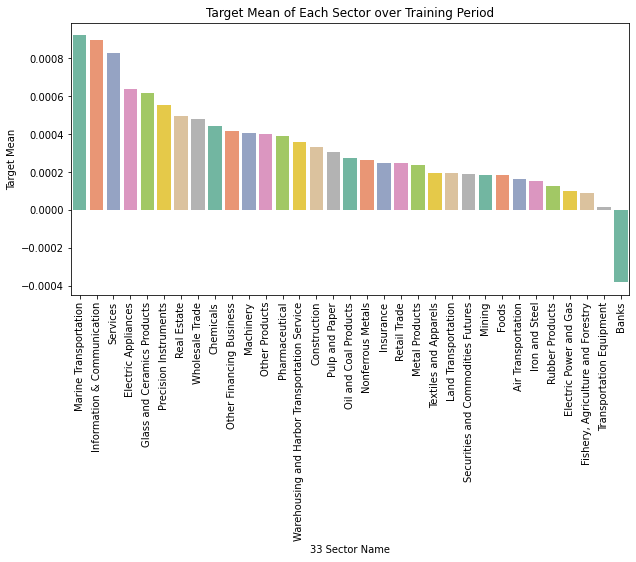

In [44]:
target_mean_33sec = df_prices.groupby(['33SectorName'])['Target'].mean()
target_mean_33sec.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=target_mean_33sec.index, y=target_mean_33sec.values, 
            palette=colors, ax=ax)
ax.set_title("Target Mean of Each Sector over Training Period")
ax.set_xlabel("33 Sector Name")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Target Mean")
plt.show()

With a broader view, we can observe that Marine Transportation has the highest target mean over the training period, followed by Information & Communication and Services. And, the only sector having negative target mean is Banks.

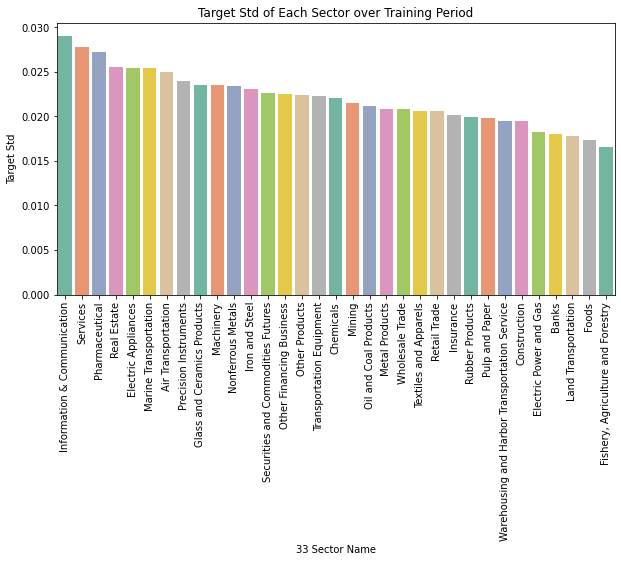

In [45]:
target_std_33sec = df_prices.groupby(['33SectorName'])['Target'].std()
target_std_33sec.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=target_std_33sec.index, y=target_std_33sec.values, 
            palette=colors, ax=ax)
ax.set_title("Target Std of Each Sector over Training Period")
ax.set_xlabel("33 Sector Name")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Target Std")
plt.show()

As for target dispersion, Information & Communication has the highest target std over the training period, followed by Services and Pharmaceutical. And, Fishery, Agriculture and Forestry has the lowest.

Let's step into the sector with the highest target mean, Marine Transportation.

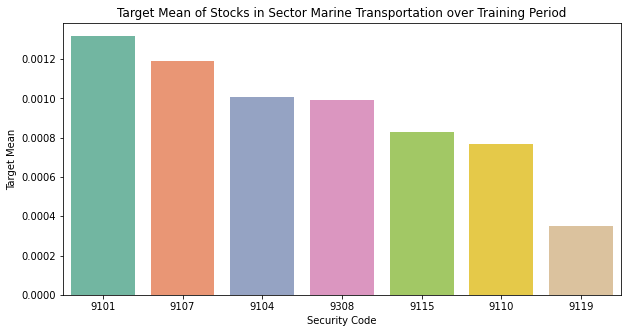

In [46]:
target_sector = 'Marine Transportation'
df_prices_marine = df_prices[df_prices['33SectorName'] == target_sector]
target_mean_marine = df_prices_marine.groupby(['SecuritiesCode'])['Target'].mean()
target_mean_marine.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=target_mean_marine.index, y=target_mean_marine.values, 
            order=target_mean_marine.index, palette=colors, ax=ax)
ax.set_title("Target Mean of Stocks in Sector Marine Transportation over Training Period")
ax.set_xlabel("Security Code")
ax.set_ylabel("Target Mean")
plt.show()


Stocks with top3 target mean are Nippon Yusen K.K. (9101), Kawasaki Kisen Kaisha, Ltd. (9107), and Mitsui OSK Lines, Ltd. (9104)
https://www.nyk.com/english/             and 
https://www.kline.co.jp/en/index.html     and
https://www.mol.co.jp/en/  

Interpreting target series on daily scale of the top3 stocks in the same sector.

In [47]:
unique_dates = sorted(df_prices['Date'].unique())

fig = go.Figure()
for stock_code in [9101, 9107, 9104]:
    df_ = df_prices_marine[df_prices_marine['SecuritiesCode'] == stock_code]
    fig.add_trace(go.Scatter(x=unique_dates, y=df_['Target'], name=stock_code))
fig.update_layout(
    title=f"Target Series of 3 Best Stocks in Marine Transportation",
)
fig.show()

we can find that stocks within the same sector have a strong spatial dependency. That is, the target series move in sync.

Let's see how target series of stocks in the worst sector, Bank, behave over the training period.

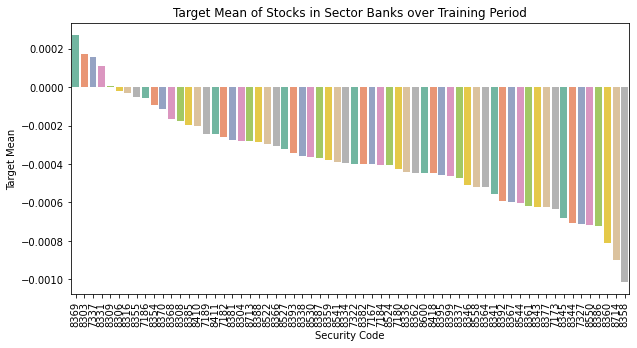

In [48]:
target_sector = 'Banks'
df_prices_banks = df_prices[df_prices['33SectorName'] == target_sector]
target_mean_banks = df_prices_banks.groupby(['SecuritiesCode'])['Target'].mean()
target_mean_banks.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=target_mean_banks.index, y=target_mean_banks.values, 
            order=target_mean_banks.index, palette=colors, ax=ax)
ax.set_title("Target Mean of Stocks in Sector Banks over Training Period")
ax.set_xlabel("Security Code")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Target Mean")
plt.show()

As we can see, the behavior is significantly different from that of the best sector, Marine Transportation. Only five of the stocks have positive target means. And, Suruga Bank Ltd. (8358) has the worst performance on average. Following is the of the official website of this company: https://www.surugabank.co.jp/surugabank/common/english/

Again, let's observe target series on daily scale

In [49]:
fig = go.Figure()
for stock_code in [8360, 8714, 8358]:
    df_ = df_prices_banks[df_prices_banks['SecuritiesCode'] == stock_code]
    fig.add_trace(go.Scatter(x=unique_dates, y=df_['Target'], name=stock_code))
fig.update_layout(
    title=f"Target Series of 3 Worst Stocks in Banks",
)
fig.show()

Stocks within the same sector have some interrelationship with each other. That is, the target series move in sync.

Finally, let's verify if stocks from different sectors have the relationship observed above. I select stocks 9101, 9104, 8714 and 8358 to illustrate the statement

In [50]:
fig = go.Figure()
for stock_code in [9101, 9104, 8714, 8358]:
    df_ = df_prices[df_prices['SecuritiesCode'] == stock_code]
    fig.add_trace(go.Scatter(x=unique_dates, y=df_['Target'], name=stock_code))
fig.update_layout(
    title=f"Target Series of 2 Best Stocks in Marine Transportation and 2 Worst in Banks",
)
fig.show()

Apparently, target series from different sectors have weaker spatial dependency compared with those from the same sector.

In [52]:
price_data = df_prices[df_prices["SecuritiesCode"] == 1301]

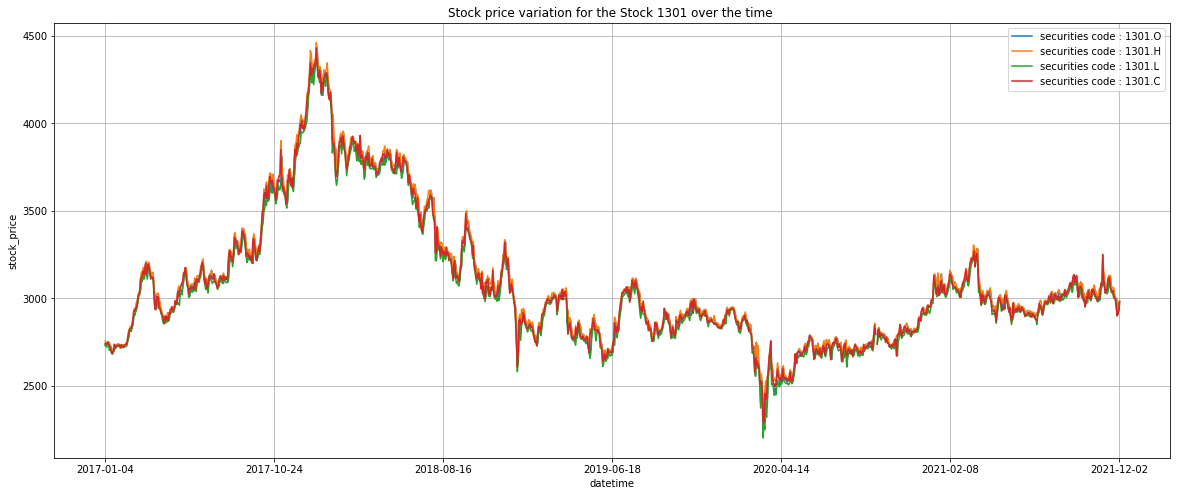

In [59]:
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(price_data['Date'],price_data["Open"], label=f"securities code : {1301}.O")
ax.plot(price_data['Date'],price_data["High"], label=f"securities code : {1301}.H")
ax.plot(price_data['Date'],price_data["Low"], label=f"securities code : {1301}.L")
ax.plot(price_data['Date'],price_data["Close"], label=f"securities code : {1301}.C")
plt.xticks([0, 200,400,600,800, 1000,1200])
ax.set_title("Stock price variation for the Stock 1301 over the time ")
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

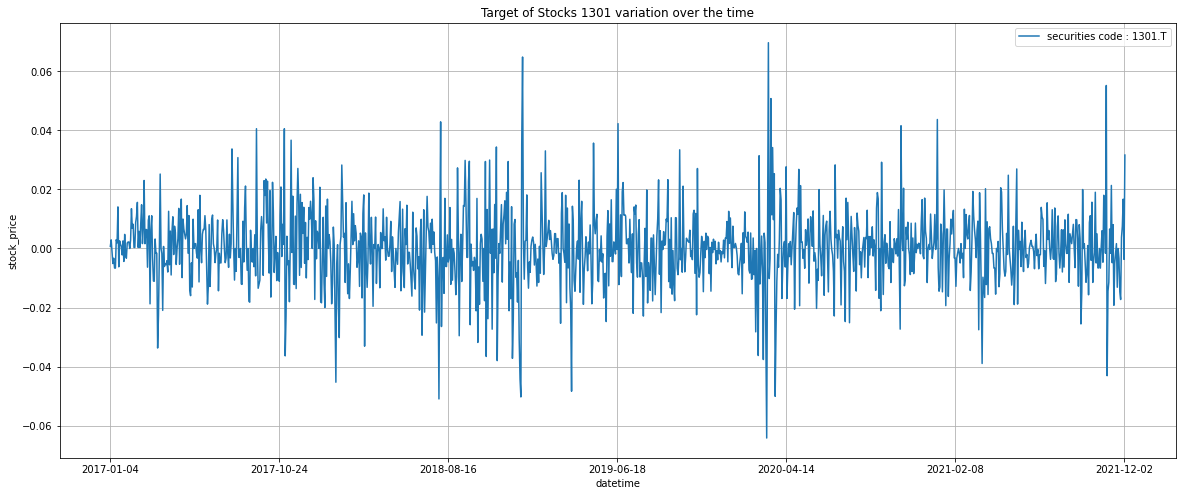

In [60]:
code = 1301
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(price_data['Date'],price_data["Target"], label=f"securities code : {code}.T")
plt.xticks([0, 200,400,600,800, 1000,1200])
ax.set_title("Target of Stocks 1301 variation over the time")
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

Moving averages There are many types of but here we will use a simple moving The average line is used. A simple moving average is For example, a 5-day line is the last 5 business days. The average of the price over the past The following is a summary of the results of the survey. This is the period Sliding down the The calculation is based on The following table shows the results.

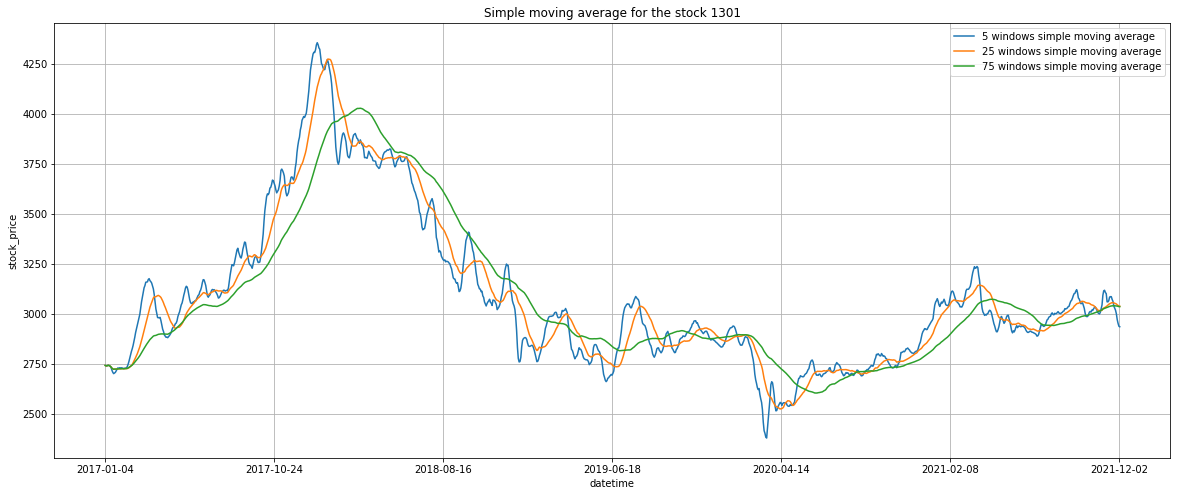

In [63]:
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows simple moving average".format(period)
    price_data[col] = price_data["Close"].rolling(period, min_periods=1).mean()
    cols.append(col)


fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data['Date'],price_data[col], label=col)
ax.set_title("Simple moving average for the stock 1301")
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
plt.xticks([0, 200,400,600,800, 1000,1200])
ax.grid(True)
ax.legend()

In [ ]:
JPX simple overfitting model with BayesianRidge
Thanks for the Paulo Pinto's notebook JPX simple overfitting model. I will experiment modeling with BayesianRidge and more based on this notebook.

import numpy as np
import pandas as pd
import jpx_tokyo_market_prediction
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import StackingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import optuna
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
def concat_df(df1, df2):
    df1 = pd.concat([df1, df2],
                    ignore_index=True, sort=False
                    ).drop_duplicates(["RowId"], keep="first")
    return df1
path = "../input/jpx-tokyo-stock-exchange-prediction/"
df_prices = pd.read_csv(f"{path}train_files/stock_prices.csv")

df_prices.info(show_counts=True)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   RowId             2332531 non-null  object 
 1   Date              2332531 non-null  object 
 2   SecuritiesCode    2332531 non-null  int64  
 3   Open              2324923 non-null  float64
 4   High              2324923 non-null  float64
 5   Low               2324923 non-null  float64
 6   Close             2324923 non-null  float64
 7   Volume            2332531 non-null  int64  
 8   AdjustmentFactor  2332531 non-null  float64
 9   ExpectedDividend  18865 non-null    float64
 10  SupervisionFlag   2332531 non-null  bool   
 11  Target            2332293 non-null  float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 198.0+ MB
def prep_prices(price):
    price.fillna(0,inplace=True)
    return price
df_prices = prep_prices(df_prices)
pd.options.display.float_format = '{:,.6g}'.format
df_prices.describe()
SecuritiesCode	Open	High	Low	Close	Volume	AdjustmentFactor	ExpectedDividend	Target
count	2.33253e+06	2.33253e+06	2.33253e+06	2.33253e+06	2.33253e+06	2.33253e+06	2.33253e+06	2.33253e+06	2.33253e+06
mean	5,894.84	2,586.05	2,617.97	2,552.87	2,585.56	691,937	1.00051	0.178075	0.000445051
std	2,404.16	3,574.42	3,616.56	3,530.75	3,573.76	3.91126e+06	0.0677304	3.33328	0.0233976
min	1,301	0	0	0	0	0	0.1	0	-0.578541
25%	3,891	1,016	1,029	1,003	1,015	30,300	1	0	-0.0104975
50%	6,238	1,806	1,828	1,784	1,806	107,100	1	0	0
75%	7,965	3,025	3,060	2,990	3,025	402,100	1	0	0.0105263
max	9,997	109,950	110,500	107,200	109,550	6.43654e+08	20	1,070	1.11951
feats = ["SecuritiesCode","Open","High","Low","Close","Volume"]

bayesian_ridge = BayesianRidge()

tree = DecisionTreeRegressor()
estimators = [
    ('bayesian_ridge', bayesian_ridge),
    ('decision_tree', tree)
]
model = StackingRegressor(
    estimators=estimators
)
model.fit(df_prices[feats],df_prices["Target"])
model.score(df_prices[feats],df_prices["Target"])
0.0013035258405520445
def calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): spread return
    """
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    buf = df.groupby('Date').apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio, buf

def add_rank(df, col_name="pred"):
    df["Rank"] = df.groupby("Date")[col_name].rank(ascending=False, method="first") - 1 
    df["Rank"] = df["Rank"].astype("int")
    return df
Predictions Ajuster
# By Yuike - https://www.kaggle.com/code/ikeppyo/examples-of-higher-scores-than-perfect-predictions

# This function adjusts the predictions so that the daily spread return approaches a certain value.
def adjuster(df):
    def calc_pred(df, x, y, z):
        return df['Target'].where(df['Target'].abs() < x, df['Target'] * y + np.sign(df['Target']) * z)

    def objective(trial, df):
        x = trial.suggest_uniform('x', 0, 0.2)
        y = trial.suggest_uniform('y', 0, 0.1)
        z = trial.suggest_uniform('z', 0, 1e-3)
        df["Rank"] = calc_pred(df, x, y, z).rank(ascending=False, method="first") - 1 
        df["Rank"] = df["Rank"].astype("int")
        return calc_spread_return_per_day(df, 200, 2)
    
    def predictor_per_day(df):
        study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=2022))
        study.optimize(lambda trial: abs(objective(trial, df) - 10), 10)
        return calc_pred(df, *study.best_params.values())

    return df.groupby("Date").apply(predictor_per_day).reset_index(level=0, drop=True)

def _predictor_base(feature_df):
    return model.predict(feature_df[feats])

def _predictor_with_adjuster(feature_df):
    feature_df["Target"] = model.predict(feature_df[feats])
    return adjuster(feature_df)
predictor = _predictor_with_adjuster
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

for prices, options, financials, trades, secondary_prices, sample_prediction in iter_test:
    current_date = prices["Date"].iloc[0]
    feature_df = df_prices[df_prices['Date'] == current_date].copy()
    feature_df["pred"] = adjuster(feature_df).iloc[0]
    feature_df = add_rank(feature_df)
    feature_map = feature_df.set_index('SecuritiesCode')['Rank'].to_dict()
    sample_prediction['Rank'] = sample_prediction['SecuritiesCode'].map(feature_map)
    env.predict(sample_prediction)
##This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


 